# Preparation

In [1]:
!wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

--2022-09-18 14:29:07--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.2’

housing.csv.2       100%[===================>]   1.36M  --.-KB/s    in 0.01s   

2022-09-18 14:29:07 (106 MB/s) - ‘housing.csv.2’ saved [1423529/1423529]



In [79]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('housing.csv')
print(df.shape)

(20640, 10)


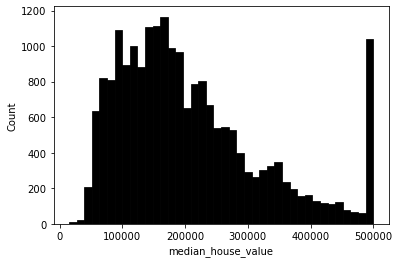

In [80]:
plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value, bins=40, color='black', alpha=1)
# plt.ylabel('Frequency')
# plt.xlabel('Price')
# plt.title('Distribution of prices')

plt.show()

# Question 1

In [81]:
df.isnull().sum()  #total_bedrooms has null values

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

# Question 2

In [82]:
df['population'].quantile(q=0.5)

1166.0

# Split and shuffle

In [83]:
#split into train/val/test
np.random.seed(2)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
#shuffle
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
#make y column
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values
#apply the log transformation to the median_house_value 
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
#delete the target value ('median_house_value') 
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [84]:
print(n)
print(df_train.shape, df_val.shape, df_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

20640
(12384, 9) (4128, 9) (4128, 9)
(12384,) (4128,) (4128,)


# Question 3

In [85]:
base = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

In [86]:
def prepare_X(df, fillna_value):
    df_num = df[base]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

In [87]:
#with 0
X_train_0 = prepare_X(df_train, 0)

#with mean
mean = df_train['total_bedrooms'].mean()
X_train_mean = prepare_X(df_train, mean)

In [88]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [89]:
#with 0
w_0_0, w_0 = train_linear_regression(X_train_0, y_train)

#with mean
w_0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

In [90]:
#with 0
y_pred_0 = w_0_0 + X_train_0.dot(w_0)

#with mean
y_pred_mean = w_0_mean + X_train_mean.dot(w_mean)

In [91]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [92]:
X_mean_val = prepare_X(df_val, fillna_value=mean)
y_mean_pred_val = w_0_mean + X_mean_val.dot(w_mean)

In [93]:
np.round(rmse(y_val, y_mean_pred_val),2)

0.33

In [94]:
X_null_val = prepare_X(df_val, fillna_value=0)
y_null_pred_val = w_0_0 + X_null_val.dot(w_0)

In [95]:
np.round(rmse(y_val, y_null_pred_val),2)

0.33

In [96]:
#ANSWER: BOTH ARE EQUAL

# Question 4

In [97]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [102]:
X_train = prepare_X(df_train, 0)
X_val = prepare_X(df_val, 0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_pred),9)
    print('%6s' %r, rmse_val)

     0 0.332091232
 1e-06 0.332091232
0.0001 0.332091219
 0.001 0.332091122
  0.01 0.332092075
   0.1 0.332251028
     1 0.336059783
     5 0.341261335
    10 0.342575485


### Answer
Round to 2 digits is not enough, so I've selected 9 digits. The smallest error is with $r=0.001$

# Question 5

In [105]:
rmses = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    #shuffle
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    #make y column
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values
    #apply the log transformation to the median_house_value 
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    #delete the target value ('median_house_value') 
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    
    #training with train
    X_null_train = prepare_X(df_train, 0)
    w_0, w = train_linear_regression(X_null_train, y_train)
    
    #validation with val
    X_null_val = prepare_X(df_val, 0)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(r, w_0, rmse_val)

10 -11.900382138199404 0.34
10 -11.732757373218973 0.34
10 -11.806729361118434 0.33
10 -11.587900347752534 0.34
10 -11.389470588135024 0.34
10 -11.44711427625141 0.34
10 -11.370516351650567 0.35
10 -12.473448918239946 0.34
10 -11.800287429404335 0.35
10 -11.459046830733227 0.34


In [107]:
#ANSWER
np.round(np.std(rmse_list),3)

0.005

# Question 6

In [111]:
#use seed=9

np.random.seed(9)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
#shuffle
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()


#concat train and val
df_train_val = pd.concat([df_train, df_val])
#make y column
y_train_val_orig = df_train_val.median_house_value.values
y_test_orig = df_test.median_house_value.values
#apply the log transformation to the median_house_value
y_train = np.log1p(y_train_val_orig)
y_test = np.log1p(y_test_orig)
#delete the target value ('median_house_value') 
del df_train_val['median_house_value']
del df_test['median_house_value']

In [121]:
#nan = 0 for train and val
X_train_val = prepare_X(df_train_val,0)
#training
w_0, w = train_linear_regression_reg(X_null_train_val, y_train_val, r=0.001)
#nan = 0 for test
X_test = prepare_X(df_test,0)
#prediction
y_pred_test = w_0 + X_test.dot(w)

np.round(rmse(y_test, y_pred_test),2)

0.35

### Answer: 0.35